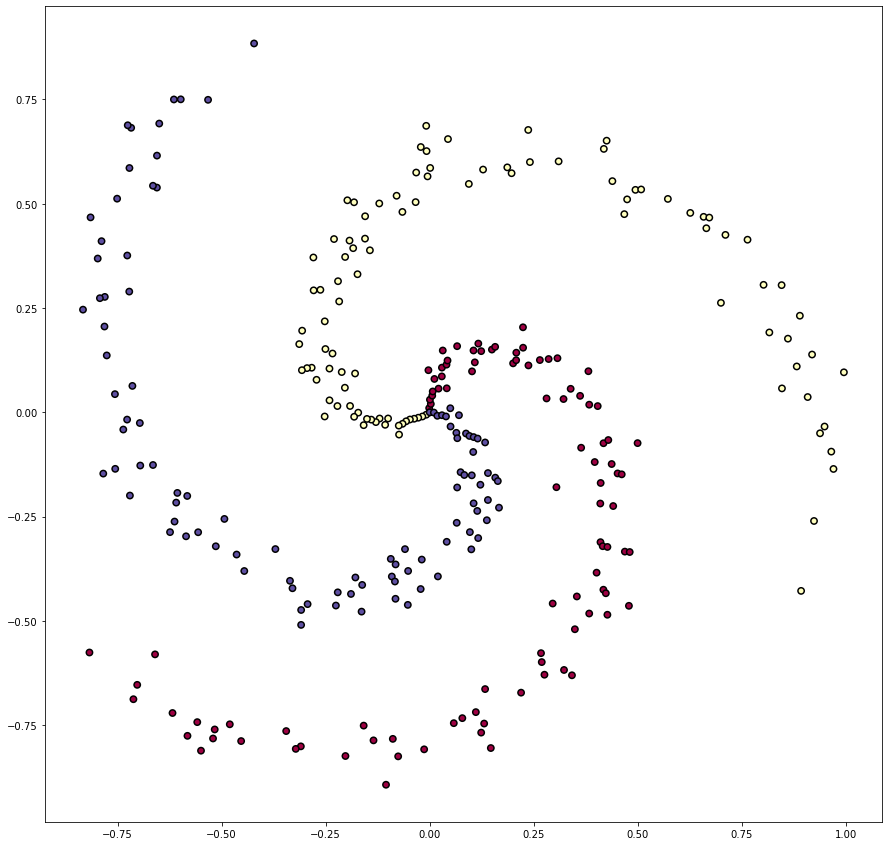

In [452]:
# following code is a copy from https://cs231n.github.io/convolutional-networks/
#used it as a dataset

import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
fig = plt.figure(figsize=(15,15))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, linewidths=1.5, edgecolors='black')
plt.show()

In [404]:
new_y = [] #OneHotEncode transform (garbage one)
for i in y:
    arre = [0,0,0]
    arre[i] = 1
    new_y.append(arre)
new_y = np.array(new_y)
print(new_y[:10])

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [405]:
class NNLayer:
    """A simple layer in CNN, uses 3 different methods for initialization"""
    W = None #weights 
    b = None #add term
    layer_size = None #size of current layer
    prev_size = None #size of prev layer
    method = None #ReLU or Sigmoid 
    output = None #calculated output
    
    def __init__(self, prev_size, layer_size, method):
        self.layer_size = layer_size
        self.prev_size = prev_size
        self.method = method
        if method == 'sigmoid': #Xavier init method
            self.W = -(1.0 / np.sqrt(prev_size)) + np.random.rand(prev_size, layer_size) * (2.0 / np.sqrt(prev_size))
        elif method == 'random':
            self.W = 0.01 * np.random.randn(prev_size,layer_size)
        elif method == 'ReLU': #He init method
            self.W = np.random.randn(prev_size, layer_size) * (2.0 / np.sqrt(prev_size))
        else:
            self.W = 0.01 * np.random.randn(prev_size,layer_size)
        self.b = np.zeros((1,layer_size))
    def calculate_layer(self, input_data): #a function calculates the output given the input
        if self.method == 'sigmoid':
            self.output = 1/(1+np.exp(-(np.dot(input_data, self.W) + self.b)))
        elif self.method == 'ReLU':
            self.output = np.maximum(0, np.dot(input_data, self.W) + self.b)
        return self.output

In [428]:
class CNN:
    input_layer = None
    output = None
    hidden_layers = []
    learning_rate = 0.01
    activation_method = 'ReLU'
    
    def __init__(self, input_layer, output, hidden_layers, learning_rate, activation_method):
        self.input_layer = input_layer
        self.output = output
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.activation_method = activation_method
    def feedForward(self):
        cur_step_arr = self.input_layer
        for layer in self.hidden_layers:
            cur_step_arr = layer.calculate_layer(cur_step_arr)
        if self.activation_method == 'ReLU':
            #convert to probability [0,1]
            exp_scores = np.exp(cur_step_arr)
            cur_step_arr = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return cur_step_arr
    
    def backProp(self, results):
        dscores = results - self.output #the difference between the two
        n_hidden_layers = len(self.hidden_layers)
        if self.activation_method == 'ReLU':
            #print(n_hidden_layers, 'num')
            for ix, layer in enumerate(self.hidden_layers[::-1]):
                if ix < n_hidden_layers - 1:
                    hidden_layer = self.hidden_layers[n_hidden_layers-ix-2].output
                else: #take the first one 
                    hidden_layer = self.input_layer

#                 dscores /= layer.layer_size
                # backpropate the gradient to the parameters
                # first backprop into parameters W2 and b2
                dW = np.dot(hidden_layer.T, dscores)
                db = np.sum(dscores, axis=0, keepdims=True)
                # next backprop into hidden layer
                dscores = np.dot(dscores, layer.W.T)
                # backprop the ReLU non-linearity
                dscores[hidden_layer <= 0] = 0
                
                # reasign weights and biases
                self.hidden_layers[n_hidden_layers-ix-1].W = self.hidden_layers[n_hidden_layers-ix-1].W - self.learning_rate*dW
                self.hidden_layers[n_hidden_layers-ix-1].b = self.hidden_layers[n_hidden_layers-ix-1].b - self.learning_rate*db
        if self.activation_method == 'sigmoid':
            for ix, layer in enumerate(self.hidden_layers[::-1]):
                if ix < n_hidden_layers - 1:
                    inputlayer = self.hidden_layers[n_hidden_layers-ix-2].output
                else: #check for the last one 
                    inputlayer = self.input_layer
                    
                #the derivative of sigmoid function
                df = (1-layer.output)*layer.output
                
                #The Hadamard Product
                delta = np.multiply(df, dscores)
                
                #transfer to next step in backprop
                dscores = np.dot(dscores, layer.W.T)
                
                #changes
                dW = np.dot(inputlayer.T,delta)
                db = np.sum(delta, axis=0, keepdims=True)
                
                self.hidden_layers[n_hidden_layers-ix-1].W -= self.learning_rate*dW
                self.hidden_layers[n_hidden_layers-ix-1].b -= self.learning_rate*db
                
    def train(self, epoch):
        for i in range(epoch):
            res = self.feedForward()
            
            if i%100==99:
                loss = np.sqrt(np.sum(np.power(res-self.output, 2)))
                print('Loss at gen {}:'.format(i+1),loss)
            self.backProp(res)
    def predict(self, new_data):
        cur_step_arr = new_data
        for layer in self.hidden_layers:
            cur_step_arr = layer.calculate_layer(cur_step_arr)
        if self.activation_method == 'ReLU':
            #convert to probability [0,1]
            exp_scores = np.exp(cur_step_arr)
            cur_step_arr = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return cur_step_arr

In [453]:
def PlotResult(X,y, Classifier):
# plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = Classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(15,15))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, linewidths=1.5, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

#fig.savefig('spiral_net.png')

In [429]:
hidden_layers = [NNLayer(2,100, 'sigmoid'), NNLayer(100,100, 'sigmoid'), NNLayer(100,3, 'sigmoid')]
Network_sigmoid = CNN(X, new_y, hidden_layers, 0.01, 'sigmoid')
Network_sigmoid.train(2000)

Loss at gen 100: 11.481033619828924
Loss at gen 200: 8.506046612256055
Loss at gen 300: 5.977559692270084
Loss at gen 400: 4.330960543127504
Loss at gen 500: 3.6012121384874614
Loss at gen 600: 3.2032337647277034
Loss at gen 700: 2.915167681083858
Loss at gen 800: 2.6884394368308624
Loss at gen 900: 2.532410063692901
Loss at gen 1000: 2.437629986753233
Loss at gen 1100: 2.3851240890000196
Loss at gen 1200: 2.3484516049662063
Loss at gen 1300: 2.2471517793667966
Loss at gen 1400: 2.184981671009609
Loss at gen 1500: 2.189438142752381
Loss at gen 1600: 2.1361935325707124
Loss at gen 1700: 2.0994620296023245
Loss at gen 1800: 2.6785814000245622
Loss at gen 1900: 2.342867793700024
Loss at gen 2000: 2.390660317859578


In [442]:
pred_class = np.argmax(Network_sigmoid.predict(X), axis=1)
print("sigmoid on train:",np.mean(pred_class == y))

sigmoid on train: 0.99


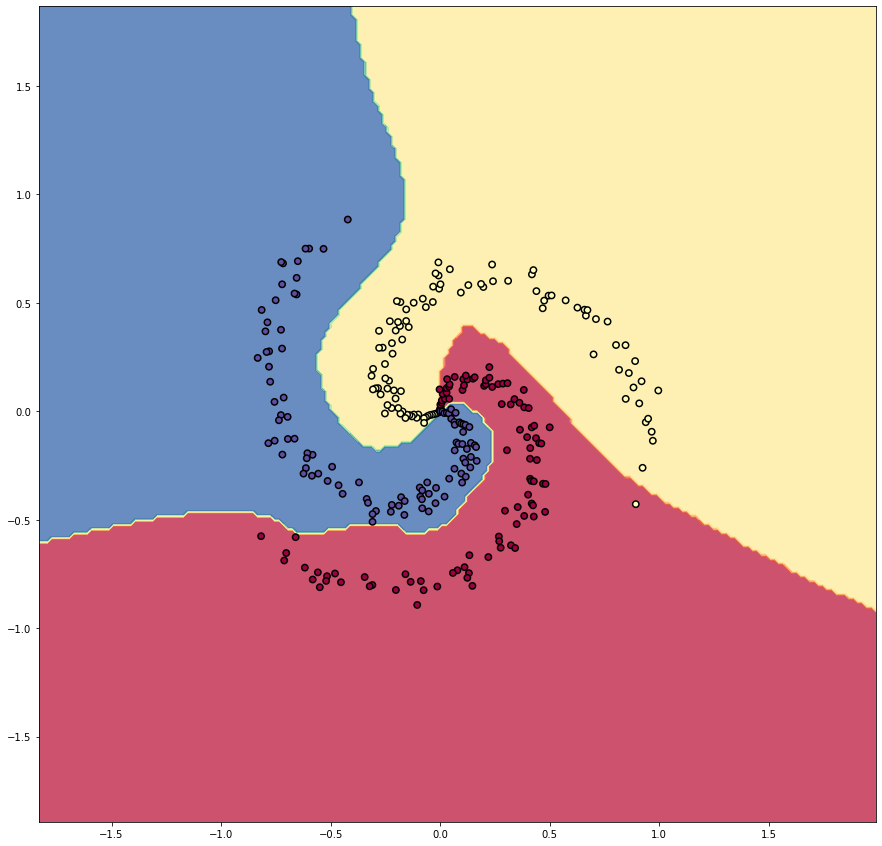

In [454]:
PlotResult(X,y, Network_sigmoid)

In [432]:
hidden_layers = [NNLayer(2,100, 'ReLU'), NNLayer(100,100, 'ReLU'), NNLayer(100,3, 'ReLU')]
Network_ReLU = CNN(X, new_y, hidden_layers, 0.001, 'ReLU')
Network_ReLU.train(2000)

Loss at gen 100: 3.3991685515347347
Loss at gen 200: 2.6825017792745425
Loss at gen 300: 2.4104635814159696
Loss at gen 400: 2.2475359959724104
Loss at gen 500: 2.135813451562358
Loss at gen 600: 2.053377042772693
Loss at gen 700: 1.9908017934778242
Loss at gen 800: 1.9411639179555205
Loss at gen 900: 1.9007538095768624
Loss at gen 1000: 1.866747606531921
Loss at gen 1100: 1.8376854993315284
Loss at gen 1200: 1.8127876632204378
Loss at gen 1300: 1.7906783169395184
Loss at gen 1400: 1.7715948762111204
Loss at gen 1500: 1.754062209266828
Loss at gen 1600: 1.7376691672855393
Loss at gen 1700: 1.7218145453498757
Loss at gen 1800: 1.7085388637661674
Loss at gen 1900: 1.6957565852078442
Loss at gen 2000: 1.6842697563556293


In [441]:
pred_class = np.argmax(Network_ReLU.predict(X), axis=1)
print("ReLU on train:",np.mean(pred_class == y))

ReLU on train: 0.9933333333333333


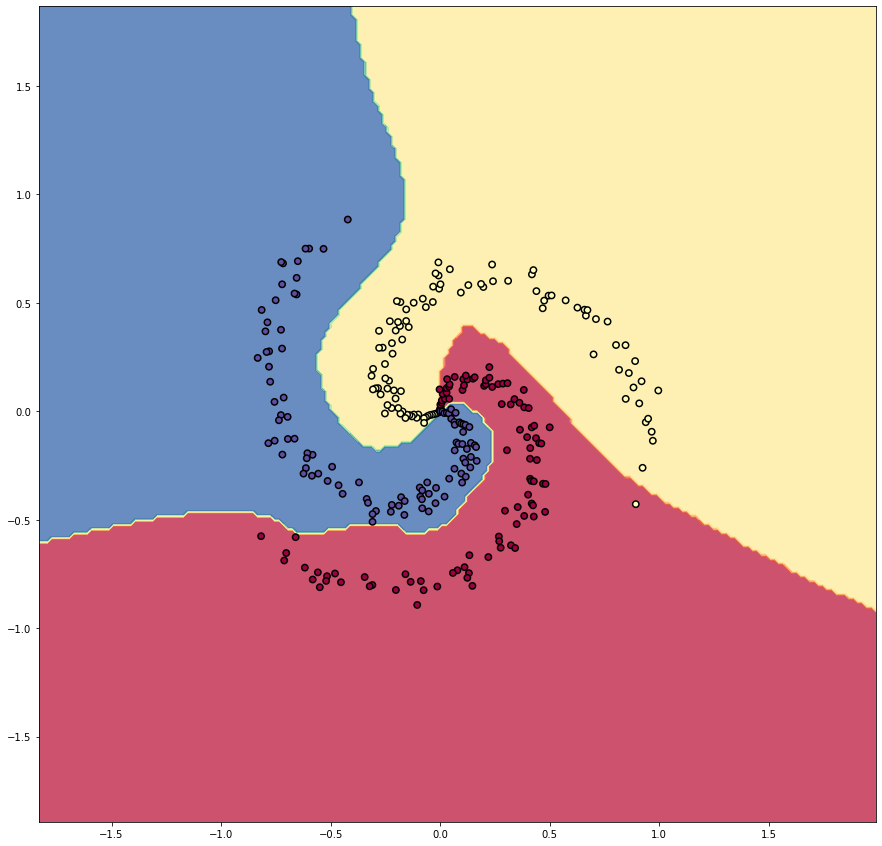

In [455]:
PlotResult(X,y, Network_ReLU)

In [458]:
#New DATA
N = 50 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X_test = np.zeros((N*K,D)) # data matrix (each row = single example)
y_test = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X_test[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y_test[ix] = j

ReLU on test: 0.98


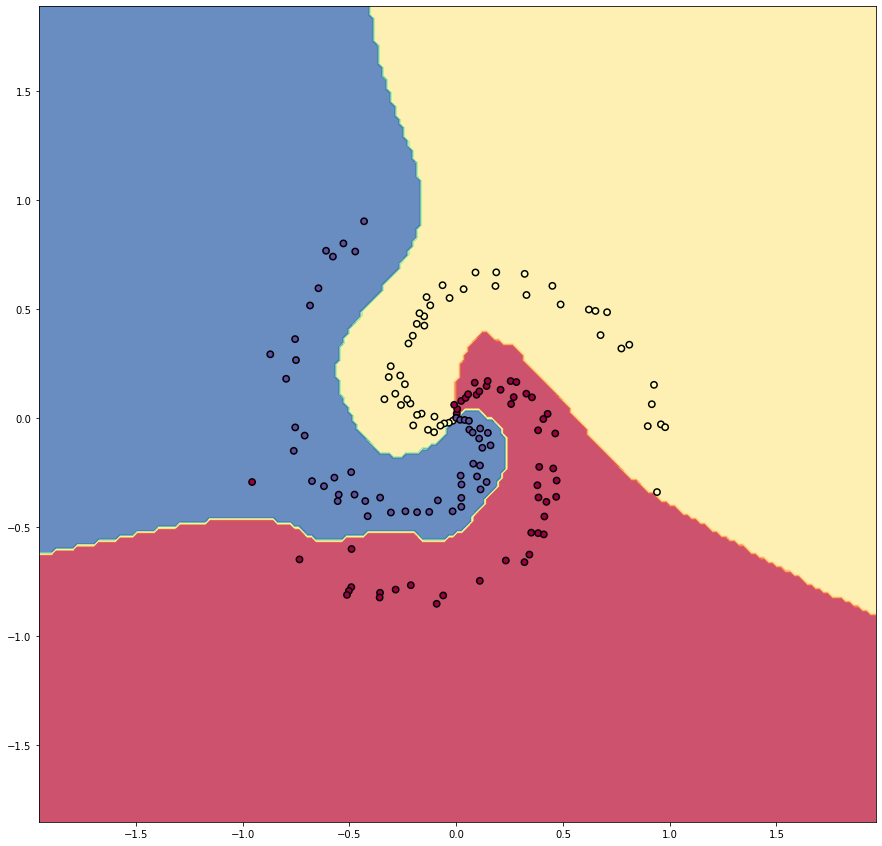

In [459]:
pred_class = np.argmax(Network_ReLU.predict(X_test), axis=1)
print("ReLU on test:",np.mean(pred_class == y_test))
PlotResult(X_test,y_test, Network_ReLU)

sigmoid on test: 0.98


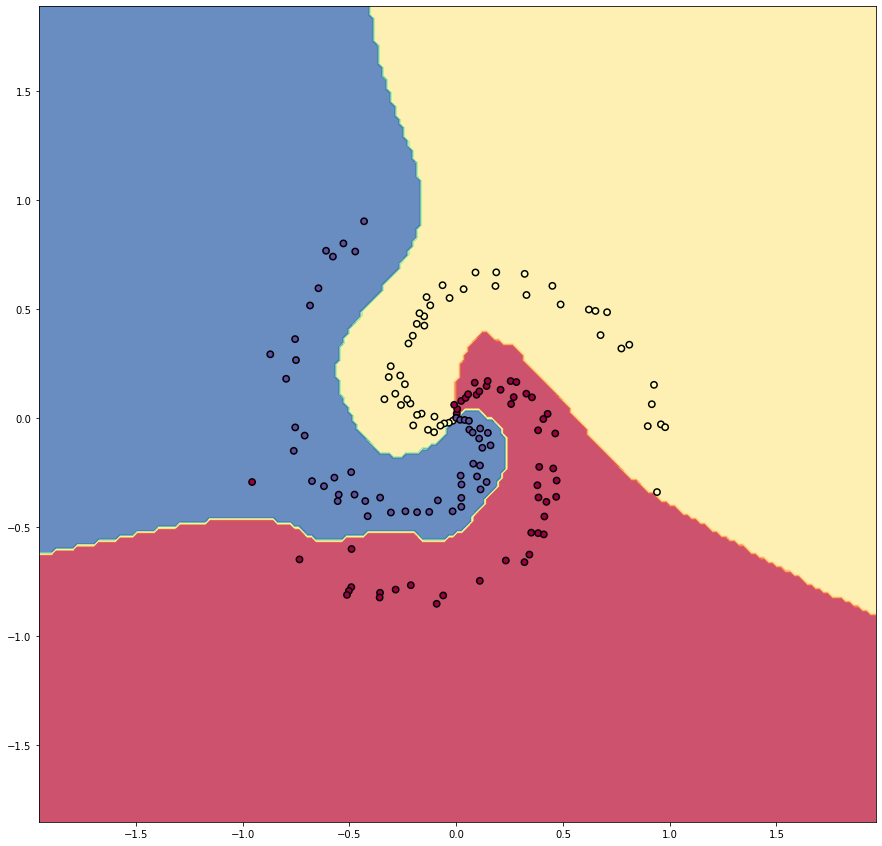

In [460]:
pred_class = np.argmax(Network_sigmoid.predict(X_test), axis=1)
print("sigmoid on test:", np.mean(pred_class == y_test))
PlotResult(X_test,y_test, Network_sigmoid)